# Football Events and Game Information

imports and initialization

In [19]:
import zipfile
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
from operator import itemgetter
from matplotlib.gridspec import GridSpec

## Exploring the data

In [2]:
df_events = pd.read_csv("events.csv")
df_game_info = pd.read_csv("ginf.csv")

In [3]:
# understand the values of some columns in events df
encoding = pd.read_table('dictionary.txt', delim_whitespace=False, names=('num','events'))
event_type=encoding[1:13]
event_type_2=encoding[14:18]
side=encoding[19:21]
shot_place=encoding[22:35]
shot_outcome=encoding[36:40]
location=encoding[41:60]
bodypart=encoding[61:64]
assist_method=encoding[65:70]
situition=encoding[71:75]

In [4]:
assist_method

,num,events
65,0,None
66,1,Pass
67,2,Cross
68,3,Headed pass
69,4,Through ball


In [5]:
# manually convert the dictionary.txt to python dicts
event_types = {1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}
event_types2 = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
sides = {1:'Home', 2:'Away'}
shot_places = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}
shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
locations = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}
bodyparts = {1:'right foot', 2:'left foot', 3:'head'}
assist_methods = {0:np.nan, 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}

In [6]:
# Mapping the dicts onto the events dataframe
df_events['event_type'] =   df_events['event_type'].map(event_types)
df_events['event_type2'] =  df_events['event_type2'].map(event_types2)
df_events['side'] =         df_events['side'].map(sides)
df_events['shot_place'] =   df_events['shot_place'].map(shot_places)
df_events['shot_outcome']=  df_events['shot_outcome'].map(shot_outcomes)
df_events['location'] =     df_events['location'].map(locations)
df_events['bodypart'] =     df_events['bodypart'].map(bodyparts)
df_events['assist_method']= df_events['assist_method'].map(assist_methods)
df_events['situation'] =    df_events['situation'].map(situations)

In [7]:
## Naming the leagues with their popular names, which will make thinks much clear for us
leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
          'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

## Map them to events
df_game_info.league = df_game_info.league.map(leagues)

In [8]:
df_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10112 entries, 0 to 10111
Data columns (total 18 columns):
id_odsp      10112 non-null object
link_odsp    10112 non-null object
adv_stats    10112 non-null bool
date         10112 non-null object
league       10112 non-null object
season       10112 non-null int64
country      10112 non-null object
ht           10112 non-null object
at           10112 non-null object
fthg         10112 non-null int64
ftag         10112 non-null int64
odd_h        10112 non-null float64
odd_d        10112 non-null float64
odd_a        10112 non-null float64
odd_over     977 non-null float64
odd_under    977 non-null float64
odd_bts      977 non-null float64
odd_bts_n    977 non-null float64
dtypes: bool(1), float64(7), int64(3), object(7)
memory usage: 1.3+ MB


# Idea: Predict Missing odds with Regression

In [9]:
df_game_info.season = df_game_info.season.astype('category')
df_game_info.league = df_game_info.league.astype('category')
df_game_info.country = df_game_info.country.astype('category')

In [10]:
df_game_info.league.unique()

[Bundesliga, League One, Premier League, La Liga, Serie A]
Categories (5, object): [Bundesliga, League One, Premier League, La Liga, Serie A]

# Data Pre-processing

## Make it in One Table

In [12]:
# Merge other dataset to have country, league, date and season
df_events = df_events.merge(df_game_info ,how = 'left')
df_events.head(3)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Key Pass,Away,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,High and wide,Off target,0,Left side of the box,left foot,Pass,Open play,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN



## Handling Missing Values

In [13]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [14]:
missing_values_table(df_events)

Your selected dataframe has 39 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
player_in,889294,94.5
player_out,889271,94.5
odd_over,842329,89.5
odd_under,842329,89.5
odd_bts,842329,89.5
odd_bts_n,842329,89.5
assist_method,773104,82.2
event_type2,726716,77.2
shot_place,713550,75.8
shot_outcome,712511,75.7


In [15]:
# Fill the required features with new class 'unknown'
df_events.shot_place.fillna('UNK', inplace= True)
df_events.player.fillna('UNK', inplace= True)
df_events.shot_outcome.fillna('UNK', inplace= True)
df_events.bodypart.fillna('UNK', inplace= True)
df_events.location.fillna('UNK', inplace= True)
df_events.assist_method.fillna('UNK', inplace= True);

In [16]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 39 columns):
id_odsp          941009 non-null object
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null object
event_type2      214293 non-null object
side             941009 non-null object
event_team       941009 non-null object
opponent         941009 non-null object
player           941009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       941009 non-null object
shot_outcome     941009 non-null object
is_goal          941009 non-null int64
location         941009 non-null object
bodypart         941009 non-null object
assist_method    941009 non-null object
situation        229137 non-null object
fast_break       941009 non-null int64
link_odsp      

In [17]:
# Notice that a lot of the floats and ints are in fact categoricals
# We can fix this with Pandas' astype function
categoricals = ['id_odsp', 'event_type', 'event_team', 'opponent', 'shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation', 'side']
d = dict.fromkeys(categoricals,'category')
df_events = df_events.astype(d)
df_events['is_goal'] = df_events['is_goal'].astype('bool') # this is a bool, we can fix that too while we're at it

In [18]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 39 columns):
id_odsp          941009 non-null category
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null category
event_type2      214293 non-null object
side             941009 non-null category
event_team       941009 non-null category
opponent         941009 non-null category
player           941009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       941009 non-null category
shot_outcome     941009 non-null category
is_goal          941009 non-null bool
location         941009 non-null category
bodypart         941009 non-null category
assist_method    941009 non-null category
situation        229137 non-null category
fast_break       941009 non-null 

# Belona Work
Which teams are the best or sloppiest at holding the lead? [Belona , Data Analysis]

First step: we find best teams holding the lead

Next step is to extract useful information from these teams’ games that made them best at holding the lead.



In [30]:
# manually chosen features
feat_cols = ['id_odsp', 'id_event', 'league', 'season', 'ht', 'at','event_team', 'is_goal']
df_data = df_events[feat_cols]

In [31]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 8 columns):
id_odsp       941009 non-null category
id_event      941009 non-null object
league        941009 non-null object
season        941009 non-null int64
ht            941009 non-null object
at            941009 non-null object
event_team    941009 non-null category
is_goal       941009 non-null bool
dtypes: bool(1), category(2), int64(1), object(4)
memory usage: 47.6+ MB


In [32]:
missing_values_table(df_data)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [33]:
#divide the data per season and per and per year
def DivideData(X):
    S =X.season.astype('category')
    L =X.league.astype('category')
    S= S.unique()
    L= L.unique()
    ll=[]
    
    for i in L:
        for j in S:
            item= [i,j]
            ll.append(item)
    ll= np.array(ll)
    return ll

In [304]:
def Classification(X):
    N,D= X.shape
    # find all theteams of the league
    ll= DivideData(X)
    for Combi in ll:
        results=[]
        Victoire=[]
        LS= X.loc[(X['league'] == Combi[0].astype(str)) & (X['season'] == Combi[1].astype(int)),:]
        print( '#########################################################' )
        print( '## the Informations about the', Combi[0], Combi[1] ,'######')
        print( '#########################################################' )
        if ((Combi[0].astype(str)=="Premier League") & ((Combi[1].astype(int)== 2012)|(Combi[1].astype(int)== 2013) )):
            
            print(" No details on the Matchs od this league")
        
        else:
            Teams= LS.iloc[:,4].unique()
            Match= LS.iloc[:,0].unique()
            Match=Match.astype(str)
            for i in range (Match.shape[0]):
                events= LS.loc[(LS['id_odsp'] == Match[i]),:]
                ht= events.iloc[1,4]
                at=events.iloc[1,5]
                butht=0
                butat=0
                for j in range (1,events.shape[0]):
                    if events.iloc[j,7]==True:
                        if (events.iloc[j,6]== ht):
                            butht = butht + 1
                        else:
                            butat= butat + 1

                if butht < butat:
                    v= at
                else:
                    if butht > butat:
                        v=ht
                    else:
                        v= 'nul'
                item=[Match[i],ht,at,butht,butat, v]
                Victoire.append(item)
            Victoire= np.array(Victoire)
            df = pd.DataFrame({'Match':Victoire[:,0], 'hote':Victoire[:,1],'oponent':Victoire[:,2],'buthote':Victoire[:,3],'butopponent':Victoire[:,4],'decision':Victoire[:,5]})

            for k in Teams :
                datateam=  df.loc[(df['hote'] == k) | (df['oponent'] == k),:]
                datateam1=  df.loc[(df['hote'] == k),:]
                N= datateam1.shape[0]
                M= datateam.shape[0]
                datavictoirehome= datateam[(datateam['decision']==k) & (datateam['hote']==k) ]['decision'].count()
                datavictoire= datateam[datateam['decision']==k]['decision'].count()
                datadefaite= datateam.loc[(datateam['decision']!= k) & (datateam['decision']!="nul"),:]
                datadefaitehome= datateam.loc[(datateam['decision']!= k) & (datateam['hote']!= k) & (datateam['decision']!="nul"),:]
                datanull= datateam[datateam['decision']=="nul"]['decision'].count()
                point= datavictoire * 3 + datanull * 1
            
                elem=[k, datavictoire, datadefaite.shape[0],datanull,point,datavictoirehome,N,M,datadefaitehome.shape[0]]
                results.append(elem)
                
            #results= sorted(results,key=itemgetter(4)) 
            results= np.array(results)
            dfresult = pd.DataFrame({'ATeam':results[:,0],'ATot':results[:,7],'ATotH':results[:,6],'BWin':results[:,1],'BWinH':results[:,5],'CDefeat':results[:,2],'CDefeatH':results[:,8],'Null':results[:,3],'Points':results[:,4]})
            dfresult=dfresult.sort_values(by=['Points'],ascending= False)
            dfresult=dfresult.tail(5)
            print(dfresult)

In [305]:
Classification(df_data)

#########################################################
## the Informations about the Bundesliga 2012 ######
#########################################################
             ATeam ATot ATotH BWin BWinH CDefeat CDefeatH Null Points
1      FC Augsburg   31    15    7     5      12        8   12     33
13      Hamburg SV   32    16    7     3      13        7   12     33
3    Hertha Berlin   33    16    7     4      16        7   10     31
4       FC Cologne   32    16    8     5      19       12    5     29
17  Kaiserslautern   33    17    4     2      19        9   10     22
#########################################################
## the Informations about the Bundesliga 2013 ######
#########################################################
                   ATeam ATot ATotH BWin BWinH CDefeat CDefeatH Null Points
9          Werder Bremen   34    17    9     5      16        9    9     36
4            FC Augsburg   34    17    8     5      17       10    9     33
11        TSG 

In [300]:
def encaissement(X):
    N,D= X.shape
    # find all theteams of the league
    ll= DivideData(X)
    for Combi in ll:
        results=[]
        Victoire=[]
        LS= X.loc[(X['league'] == Combi[0].astype(str)) & (X['season'] == Combi[1].astype(int)),:]
        print( '#########################################################' )
        print( '## the Informations about the', Combi[0], Combi[1] ,'######')
        print( '#########################################################' )
        if ((Combi[0].astype(str)=="Premier League") & ((Combi[1].astype(int)== 2012)|(Combi[1].astype(int)== 2013) )):
            
            print(" No details on the Matchs od this league")
        
        else:
            Teams= LS.iloc[:,4].unique()
            Match= LS.iloc[:,0].unique()
            Match=Match.astype(str)
            for i in range (Match.shape[0]):
                events= LS.loc[(LS['id_odsp'] == Match[i]),:]
                ht= events.iloc[1,4]
                at=events.iloc[1,5]
                butht=0
                butat=0
                butmat=0
                butmht=0
                for j in range (1,events.shape[0]):
                    if events.iloc[j,7]==True:
                        if (events.iloc[j,6]== ht):
                            butat= butat + 1
                        else:
                            butht = butht + 1
                        
                butmat= butht
                butmht=butat
                item=[Match[i],ht,at,butht,butat,butmat,butmht]
                Victoire.append(item)
            Victoire= np.array(Victoire)
            df = pd.DataFrame({'Match':Victoire[:,0], 'hote':Victoire[:,1],'oponent':Victoire[:,2],'buthote':Victoire[:,3],'butopponent':Victoire[:,4],'butmopponent':Victoire[:,5],'butmhote':Victoire[:,6]})
            
            for k in Teams :
                encaisse=0
                marque=0
                ratioM= 0
                ratioE=0
                ratioME=0
                datateam=  df.loc[(df['hote'] == k) | (df['oponent'] == k),:]
                n= datateam.shape[0]
                #print(datateam)
                for j in range (1, datateam.shape[0]):
                    if (datateam.iloc[j,5]== k):
                        encaisse += int(datateam.iloc[j,1])
                        marque+= int(datateam.iloc[j,2])
                    else:
                        encaisse += int(datateam.iloc[j,4])
                        marque+= int(datateam.iloc[j,3])
                ratioM= round(marque / n,2)
                ratioE= round (encaisse /n,2)
                ratioME= round(marque / encaisse,2)
                elem=[k,encaisse,marque,ratioE,ratioM,ratioME]
                results.append(elem)
            results= np.array(results)
            dfresult = pd.DataFrame({'ATeam':results[:,0], 'ButsEncaisses':results[:,1],'ButsMarques':results[:,2],'RatioE':results[:,3], 'RatioM':results[:,4],'RatioME':results[:,5]})
            dfresult=dfresult.sort_values(by=['RatioME'],ascending=False)
            print(dfresult)

In [301]:
encaissement(df_data)

#########################################################
## the Informations about the Bundesliga 2012 ######
#########################################################
                       ATeam ButsEncaisses ButsMarques RatioE RatioM RatioME
8              Bayern Munich            22          72   0.69   2.25    3.27
0          Borussia Dortmund            23          74    0.7   2.24    3.22
14  Borussia Monchengladbach            24          48   0.71   1.41     2.0
9                 Schalke 04            40          69   1.21   2.09    1.73
5              VfB Stuttgart            43          58    1.3   1.76    1.35
16          Bayer Leverkusen            41          50   1.24   1.52    1.22
10            TSG Hoffenheim            42          39   1.27   1.18    0.93
6                Hannover 96            41          36   1.24   1.09    0.88
7                      Mainz            51          43    1.5   1.26    0.84
11                  Nurnberg            44          35   1.38

In [39]:
def AllinfosPerLeague(league):
    Marques=[]
    Encaisse=[]
    LS= df_data.loc[(df_data['league'] == league),:]
    Seasons =LS.season.unique()
    for season in Seasons:
        LS= df_data.loc[(df_data['league'] == league) & (df_data['season'] == season),:]
        Teams= LS.iloc[:,4].unique()
        Match= LS.iloc[:,0].unique()
        Victoire=[]
        defaite=[]
        for i in range (Match.shape[0]):
            events= LS.loc[(LS['id_odsp'] == Match[i]),:]
            ht= events.iloc[1,4]
            at=events.iloc[1,5]
            butat=0
            butht=0
            butrat=0
            butrht=0
            for j in range (1,events.shape[0]):
                if events.iloc[j,7]==True:
                    if (events.iloc[j,6]== ht):
                        butht = butht + 1
                    else:
                        butat= butat + 1
            butrat= butht
            butrht=butat
            item=[Match[i],ht,at,butat,butht,butrht,butrat]
            Victoire.append(item)
        Victoire= np.array(Victoire)
        df = pd.DataFrame({'Match':Victoire[:,0], 'hote':Victoire[:,1],'oponent':Victoire[:,2],'butmopponent':Victoire[:,3],'butmhote':Victoire[:,4],'butrhote':Victoire[:,5],'butropponent':Victoire[:,6]})
       
        for k in Teams :
            marque=0
            encaisse=0
            datateam= df.loc[(df['hote'] == k) | (df['oponent'] == k),:]
            #print(datateam)
            for j in range (1, datateam.shape[0]):
                if (datateam.iloc[j,5]== k):
                    marque += int(datateam.iloc[j,1])
                    encaisse += int(datateam.iloc[j,3])
                else:
                    marque+= int(datateam.iloc[j,2])
                    encaisse += int(datateam.iloc[j,4])
            elem=[k,marque,season]
            elem1=[k,encaisse,season]
            Marques.append(elem)
            Encaisse.append(elem1)
    Marques= np.array(Marques)
    Encaisse= np.array(Encaisse)
    dfMarques = pd.DataFrame({'ATeam':Marques[:,0],'ButsMarques':Marques[:,1],'Season':Marques[:,2]})
    dfEncaisse = pd.DataFrame({'ATeam':Encaisse[:,0],'ButsRecus':Encaisse[:,1],'Season':Encaisse[:,2]})
    return dfMarques,dfEncaisse

In [40]:
dfMarques,dfEncaisse = AllinfosPerLeague("Premier League")

In [223]:
#function for justifying the best teams
#theirs behaviours at home (Number of Goals )
def teambehaviours(team):
    Seasons =df_data.season.unique()
    results=[]
    for season in Seasons:
        LS=df_data.loc[((df_data['ht'] == team) | (df_data['at'] == team)) & (df_data['season'] == season),:]
        Match= LS.iloc[:,0].unique()
        N= Match.shape[0]
        ls=(LS.loc[(LS['is_goal']==True) & (LS['event_team']==team),:]).shape[0]
        ls1=(LS.loc[(LS['is_goal']==True) & (LS['event_team']!=team),:]).shape[0]
        NbrGoalHome=(LS.loc[(LS['ht']==team) & (LS['is_goal']==True) & (LS['event_team']==team),:]).shape[0]
        if N==0:
            r=0
            r1=0
            rME=0
        else:
            r= round(ls/N,2)
            r1=round(ls1/N,2)
            rME= round(ls/ls1, 2)
        #item=[season,N,ls,NbrGoalHome,ls-NbrGoalHome,ls1,r]
        item=[season,N,ls,NbrGoalHome,ls-NbrGoalHome,ls1,r,r1,rME]
        results.append(item)
    results= np.array(results)
    dfresults = pd.DataFrame({'Seasons':results[:,0],'BMatch':results[:,1],'TotalGoals':results[:,2],'GoalsHome':results[:,3],'GoalsOutside':results[:,4],'GoalsReceive':results[:,5],'RatioM':results[:,6],'RatioE':results[:,7],'RatioME':results[:,8]})
    #dfresults = pd.DataFrame({'ASeasons':results[:,0],'BMatch':results[:,1],'CTotalGoals':results[:,2],'GoalsHome':results[:,3],'GoalsOutside':results[:,4],'GoalsReceive':results[:,5],'RatioM':results[:,6]})
    return dfresults  

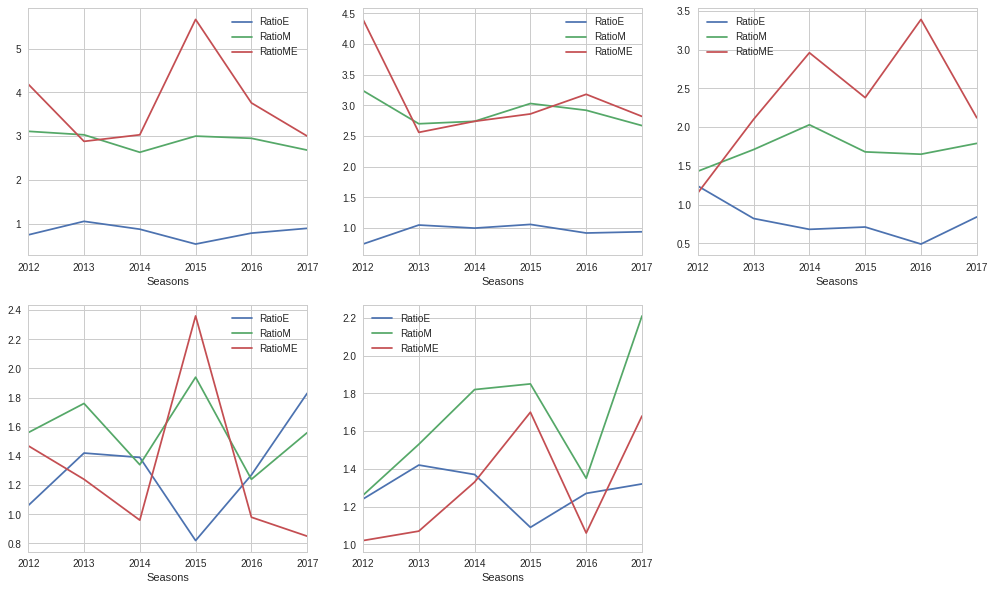

In [298]:
df=teambehaviours('Barcelona')
df1=teambehaviours('Real Madrid')
df2=teambehaviours('Atletico Madrid')
df3=teambehaviours('Valencia')
df4=teambehaviours('Sevilla')

fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
#plt.title('Ratio of best teams of Liga From 2012 to 2017, respectively: Barcelona,Real Madrid, atletico madrid, Valencia and sevilla')
df.plot(kind='line',x='Seasons',y=['RatioE','RatioM','RatioME'],ax=ax1,figsize=(17,10))
df1.plot(kind='line',x='Seasons',y=['RatioE','RatioM','RatioME'],ax=ax2)
df2.plot(kind='line',x='Seasons',y=['RatioE','RatioM','RatioME'],ax=ax3)
df3.plot(kind='line',x='Seasons',y=['RatioE','RatioM','RatioME'],ax=ax4)
df4.plot(kind='line',x='Seasons',y=['RatioE','RatioM','RatioME'],ax=ax5)
plt.savefig('ratiobestperseason.jpg', format='jpg', dpi=1000)

In [225]:
df

,BMatch,GoalsHome,GoalsOutside,GoalsReceive,RatioE,RatioM,RatioME,Seasons,TotalGoals
0,35.0,72.0,37.0,26.0,0.74,3.11,4.19,2012.0,109.0
1,38.0,63.0,52.0,40.0,1.05,3.03,2.88,2013.0,115.0
2,38.0,64.0,36.0,33.0,0.87,2.63,3.03,2014.0,100.0
3,34.0,59.0,43.0,18.0,0.53,3.00,5.67,2015.0,102.0
4,37.0,67.0,42.0,29.0,0.78,2.95,3.76,2016.0,109.0
5,19.0,23.0,28.0,17.0,0.89,2.68,3.00,2017.0,51.0


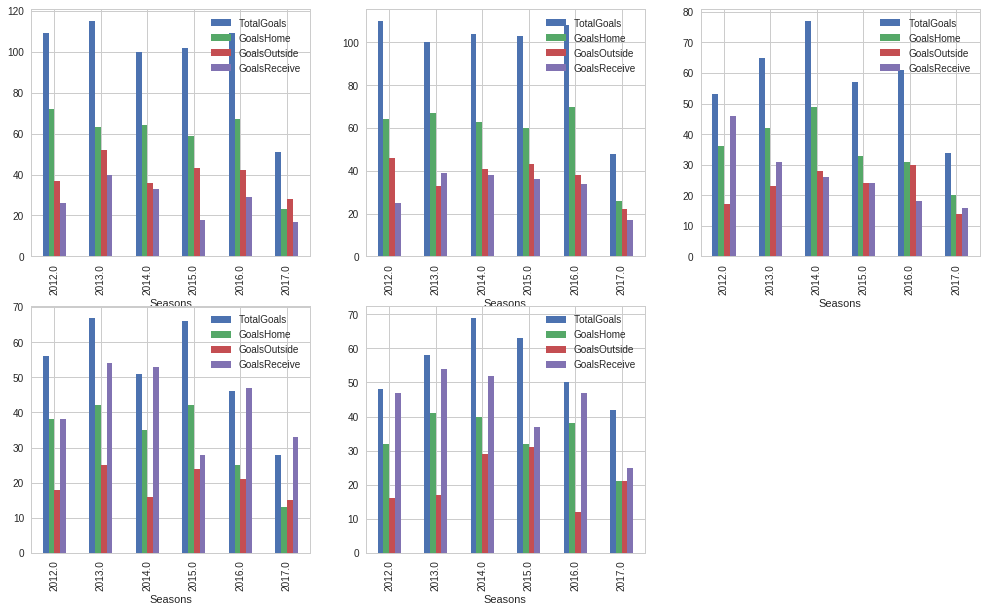

In [297]:
fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
df.plot.bar(x='Seasons',y=['TotalGoals','GoalsHome','GoalsOutside','GoalsReceive'],ax=ax1,figsize=(17,10))
df1.plot.bar(x='Seasons',y=['TotalGoals','GoalsHome','GoalsOutside','GoalsReceive'],ax=ax2)
df2.plot.bar(x='Seasons',y=['TotalGoals','GoalsHome','GoalsOutside','GoalsReceive'],ax=ax3)
df3.plot.bar(x='Seasons',y=['TotalGoals','GoalsHome','GoalsOutside','GoalsReceive'],ax=ax4)
df4.plot.bar(x='Seasons',y=['TotalGoals','GoalsHome','GoalsOutside','GoalsReceive'],ax=ax5)

plt.savefig('Numbergoalsbestteams.jpg', format='jpg', dpi=1000)

In [169]:
dfDortmund= teambehaviours("Montpellier") 
dfDortmund

,ASeasons,BMatch,CTotalGoals,GoalsHome,GoalsOutside,GoalsReceive,RatioE,RatioM,RatioME
0,2012.0,38.0,68.0,37.0,31.0,34.0,0.89,1.79,2.00
1,2013.0,37.0,52.0,33.0,19.0,51.0,1.38,1.41,1.02
2,2014.0,38.0,45.0,22.0,23.0,53.0,1.39,1.18,0.85
3,2015.0,38.0,46.0,30.0,16.0,39.0,1.03,1.21,1.18
4,2016.0,37.0,49.0,26.0,23.0,45.0,1.22,1.32,1.09
5,2017.0,21.0,29.0,17.0,12.0,33.0,1.57,1.38,0.88


In [272]:
def typeLeague(league):
    LS=df_data.loc[(df_data['league'] == league),:]
    Seasons =LS.season.unique()
    
    results=[]
    for season in Seasons:
        LS=df_data.loc[(df_data['league'] == league) & (df_data['season'] == season),:]
        Match= LS.iloc[:,0].unique()
        tMatch= Match.shape[0]
        i=0
        N=0
        while (i < LS.shape[0]):
            if LS.iloc[i,7]==True:
                N+=1
            i+=1
        item=[int(season),int(N), round(N/tMatch,2)]
        results.append(item)
    results= np.array(results)
    dfresults = pd.DataFrame({'Seasons':results[:,0],'NMatch':results[:,1],'Ratio':results[:,2]})
    return dfresults 

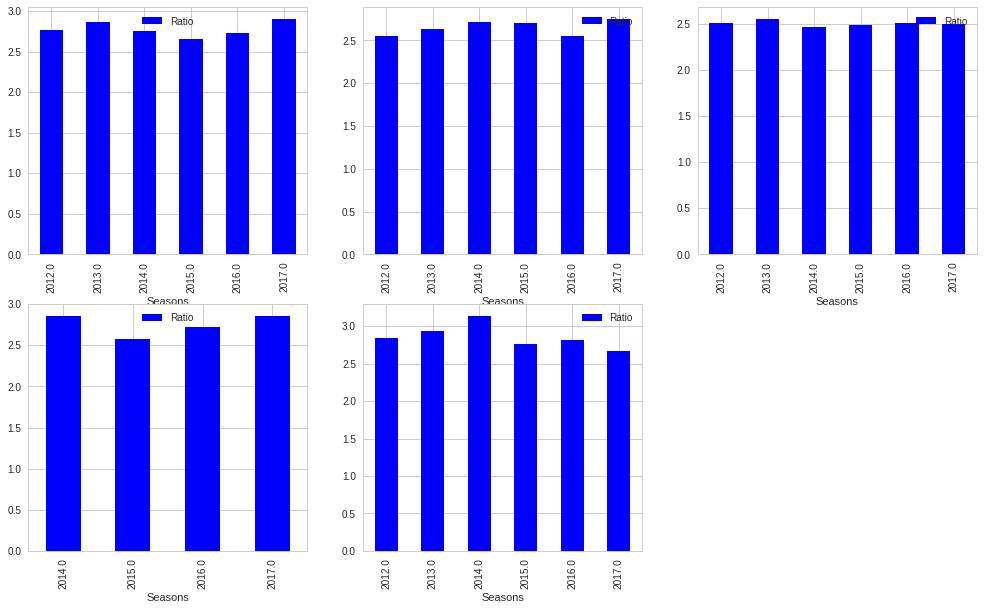

In [299]:
df= typeLeague("La Liga")
df1= typeLeague("Serie A")
df2= typeLeague("League One")
df3= typeLeague("Premier League")
df4= typeLeague("Bundesliga")
fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
df.plot(kind='bar',x='Seasons',y='Ratio',color='blue',ax=ax1,figsize=(17,10))
df1.plot(kind='bar',x='Seasons',y='Ratio',color='blue',ax=ax2)
df2.plot(kind='bar',x='Seasons',y='Ratio',color='blue',ax=ax3)
df3.plot(kind='bar',x='Seasons',y='Ratio',color='blue',ax=ax4)
df4.plot(kind='bar',x='Seasons',y='Ratio',color='blue',ax=ax5)
plt.savefig('Numbergoalsperseason.jpg', format='jpg', dpi=1000, )

# Lionel Part

In [36]:
## Loading dataset
df_events = pd.read_csv("events.csv")
df_game_info = pd.read_csv("ginf.csv")

In [37]:
# manually convert the dictionary.txt to python dicts
event_types = {1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}
event_types2 = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
sides = {1:'Home', 2:'Away'}
shot_places = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}
shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
locations = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}
bodyparts = {1:'right foot', 2:'left foot', 3:'head'}
assist_methods = {0:np.nan, 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}

In [38]:
# Mapping the dicts onto the events dataframe
df_events['event_type'] =   df_events['event_type'].map(event_types)
df_events['event_type2'] =  df_events['event_type2'].map(event_types2)
df_events['side'] =         df_events['side'].map(sides)
df_events['shot_place'] =   df_events['shot_place'].map(shot_places)
df_events['shot_outcome']=  df_events['shot_outcome'].map(shot_outcomes)
df_events['location'] =     df_events['location'].map(locations)
df_events['bodypart'] =     df_events['bodypart'].map(bodyparts)
df_events['assist_method']= df_events['assist_method'].map(assist_methods)
df_events['situation'] =    df_events['situation'].map(situations)

In [39]:
## Naming the leagues with their popular names, which will make thinks much clear for us
leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
          'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

## Map them to events
df_game_info.league = df_game_info.league.map(leagues)

In [44]:
# Merge other dataset to have country, league, date and season
df_events = df_events.merge(df_game_info ,how = 'left')

In [45]:
## Utility function to plot bar plots with similar configuration
## this function was took from this website : 
#https://www.kaggle.com/luizhsda/football-exploratory-data-analysis-eda
def plot_barplot(data, x_ticks, x_labels, y_labels, title, color='muted'):
    ## Set standard style as whitegrid (this also could be customized via param)
    sns.set_style("whitegrid")   # Proposed themes: darkgrid, whitegrid, dark, white, and ticks

    ## Set a figure with custom figsize
    #plt.figure(figsize=(num, figsize)) num=10, figsize=8
    ## Plottin data
    ax = sns.barplot(x = [j for j in range(0, len(data))], y=data.values, palette=color)
    ## Setting ticks extracted from data indexes
    ax.set_xticks([j for j in range(0, len(data))])
    ## Set labels of the chart
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set(xlabel = x_labels, ylabel = y_labels, title = title)
    ax.plot();
    plt.tight_layout()

## When are teams more likely to score?

In [46]:
## grouping by player when is goal
goal = df_events[df_events['is_goal']==1]

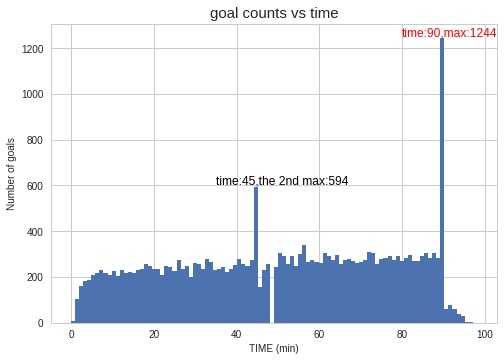

In [47]:
## Plotting the hist
plt.hist(goal.time, 100)
plt.xlabel("TIME (min)",fontsize=10)
plt.ylabel("Number of goals",fontsize=10)
plt.title("goal counts vs time",fontsize=15)
x=goal.groupby(by='time')['time'].count().sort_values(ascending=False).index[0]
y=goal.groupby(by='time')['time'].count().sort_values(ascending=False).iloc[0]
x1=goal.groupby(by='time')['time'].count().sort_values(ascending=False).index[1]
y1=goal.groupby(by='time')['time'].count().sort_values(ascending=False).iloc[1]
plt.text(x=x-10,y=y+10,s='time:'+str(x)+',max:'+str(y),fontsize=12,fontdict={'color':'red'})
plt.text(x=x1-10,y=y1+10,s='time:'+str(x1)+',the 2nd max:'+str(y1),fontsize=12,fontdict={'color':'black'})
plt.savefig('goals.jpg', format='jpg', dpi=1000)
plt.show() 

## What is the most and less offensive team?

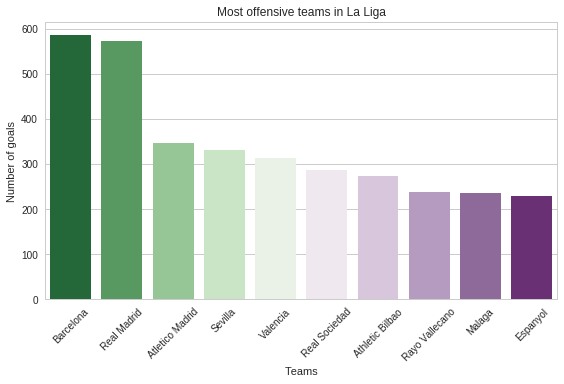

In [48]:
## Grouping attempts by team
group_by_offensive = df_events[df_events['league']=='La Liga'][df_events['is_goal']==1].groupby('event_team')

## Sorting the values
group_by_offensive = group_by_offensive.count().sort_values(by='id_event', ascending=False)[:10]
teams = group_by_offensive.index
scores = group_by_offensive['id_event']

## Plotting the teams
plot_barplot(scores, teams, 'Teams', 'Number of goals', 'Most offensive teams in La Liga','PRGn_r')
plt.savefig('offensiveteam.jpg', format='jpg', dpi=1000)

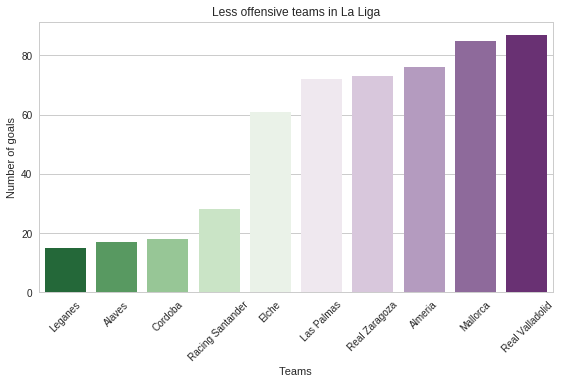

In [51]:
## Grouping attempts by team
group_by_offensive = df_events[df_events['league']=='La Liga'][df_events['is_goal']==1].groupby('event_team')

## Sorting the values
group_by_offensive = group_by_offensive.count().sort_values(by='id_event', ascending=True)[:10]
teams = group_by_offensive.index
scores = group_by_offensive['id_event']

## Plotting the teams
plot_barplot(scores, teams, 'Teams', 'Number of goals', 'Less offensive teams in La Liga', 'PRGn_r')
plt.savefig('lessoffensiveteam.jpg', format='jpg', dpi=1000)

## The Most offensive player in La Liga from 2012 to 2017

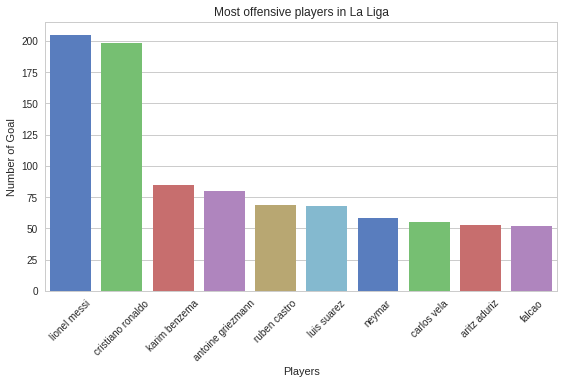

In [52]:
## grouping by player when is goal
group_by_offensive_player = df_events[df_events['league']=='La Liga'][df_events['is_goal']==1].groupby('player')

## Couting and sorting the number of goals by player, then pick the top 10
group_by_offensive_player = group_by_offensive_player.count().sort_values(by='id_event',
                                                                                ascending=False)[:10]
## Extracting player names
players = group_by_offensive_player.index
## Extracting values (# of goals)
scores = group_by_offensive_player['id_event']

## Plotting the chart
plot_barplot(scores, players, 'Players', 'Number of Goal', 'Most offensive players in La Liga')
plt.savefig('offensiveteamplayer.jpg', format='jpg', dpi=1000)

## The Number of red cards per team in La Liga from 2012 to 2017

In [55]:
redCards = df_events[df_events['league']=='La Liga'][df_events['event_type'] == 'Red card']['event_team']

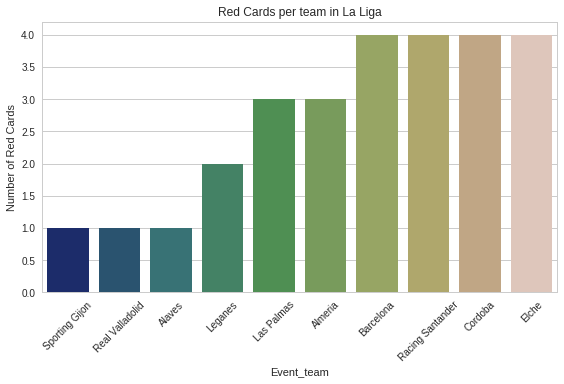

In [56]:
## Count of events occurecies
redCards_series = redCards.value_counts().sort_values(ascending=True)[:10]

## Plotting chart 
plot_barplot(redCards_series, redCards_series.index,
            "Event_team", "Number of Red Cards", "Red Cards per team in La Liga", 'gist_earth')
plt.savefig('redcard.jpg', format='jpg', dpi=1000)

## Some statistics for Barcelona

Index(['Corner', 'Free kick', 'Open play', 'Set piece'], dtype='object', name='situation')


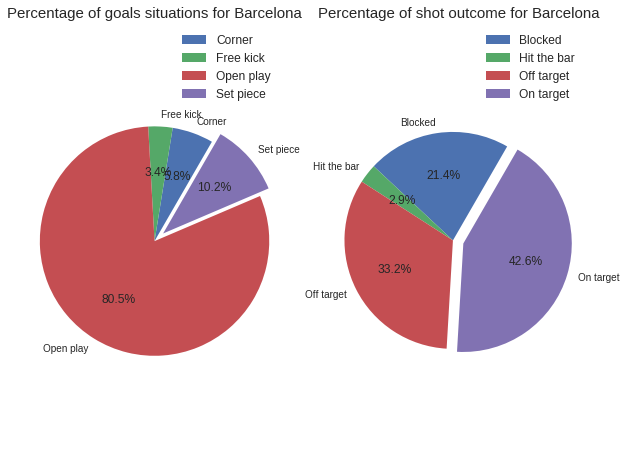

In [63]:
the_grid = GridSpec(1, 2)
goal = df_events[df_events['event_team']=='Barcelona'][df_events['league']=='La Liga'][df_events['is_goal'] == 1]
goal1=goal.copy()
plt.figure(figsize=(10,8))

data1=goal1.groupby(by=['situation'])['situation'].count()
plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(data1,autopct='%1.1f%%',labels=data1.index,startangle=60,explode=(0,0,0,0.1))
plt.axis('equal')
plt.title("Percentage of goals situations for Barcelona",fontsize=15)
plt.legend(fontsize=12,loc='best')

goals = df_events[df_events['event_team']=='Barcelona'][df_events['league']=='La Liga']
goals1=goals.copy()
data2=goals1.groupby(by=['shot_outcome'])['shot_outcome'].count()
colors=["green", "red","yellow", "pink"]
plt.subplot(the_grid[0, 1], aspect=1)
plt.pie(data2,autopct='%1.1f%%',labels=data2.index,startangle=60,explode=(0,0,0,0.1))
plt.axis('equal')
plt.title("Percentage of shot outcome for Barcelona",fontsize=15)
plt.legend(fontsize=12,loc='best')
plt.savefig('barca.jpg', format='jpg', dpi=1000)
plt.show()

## Some statistics for Real Madrid

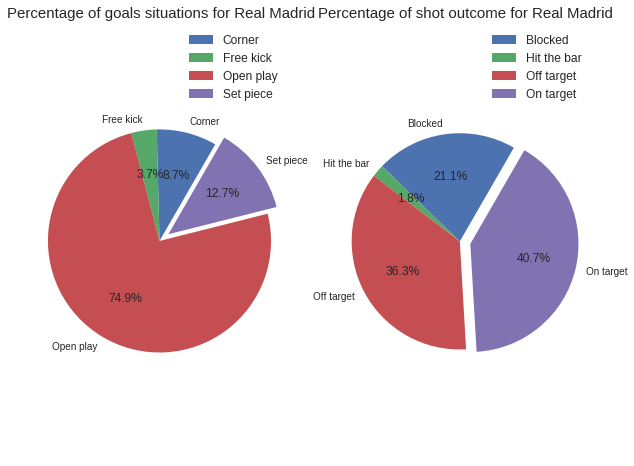

In [64]:
the_grid = GridSpec(1, 2)
goal = df_events[df_events['event_team']=='Real Madrid'][df_events['league']=='La Liga'][df_events['is_goal'] == 1]
goal1=goal.copy()
plt.figure(figsize=(10,8))

data1=goal1.groupby(by=['situation'])['situation'].count()
plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(data1,autopct='%1.1f%%',labels=data1.index,startangle=60,explode=(0,0,0,0.1))
plt.axis('equal')
plt.title("Percentage of goals situations for Real Madrid",fontsize=15)
plt.legend(fontsize=12,loc='best')


goals = df_events[df_events['event_team']=='Real Madrid'][df_events['league']=='La Liga']
goals1=goals.copy()
data2=goals1.groupby(by=['shot_outcome'])['shot_outcome'].count()
colors=["green", "red","yellow", "pink"]
plt.subplot(the_grid[0, 1], aspect=1)
plt.pie(data2,autopct='%1.1f%%',labels=data2.index,startangle=60,explode=(0,0,0,0.1))
plt.axis('equal')
plt.title("Percentage of shot outcome for Real Madrid",fontsize=15)
plt.legend(fontsize=12,loc='best')
plt.savefig('realmadrid.jpg', format='jpg', dpi=1000)
plt.show()

## Some statistics for Barcelona vs Real Madrid

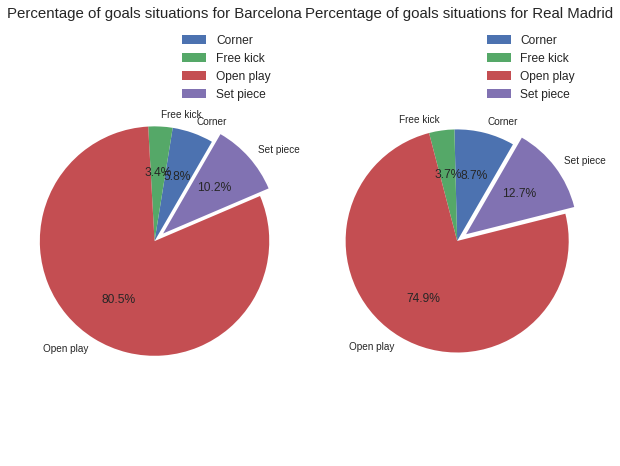

In [65]:
the_grid = GridSpec(1, 2)
goal = df_events[df_events['event_team']=='Barcelona'][df_events['league']=='La Liga'][df_events['is_goal'] == 1]
goal1=goal.copy()
plt.figure(figsize=(10,8))

data1=goal1.groupby(by=['situation'])['situation'].count()
plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(data1,autopct='%1.1f%%',labels=data1.index,startangle=60,explode=(0,0,0,0.1))
plt.axis('equal')
plt.title("Percentage of goals situations for Barcelona",fontsize=15)
plt.legend(fontsize=12,loc='best')

goal = df_events[df_events['event_team']=='Real Madrid'][df_events['league']=='La Liga'][df_events['is_goal'] == 1]
goal1=goal.copy()
data1=goal1.groupby(by=['situation'])['situation'].count()
plt.subplot(the_grid[0, 1], aspect=1)
plt.pie(data1,autopct='%1.1f%%',labels=data1.index,startangle=60,explode=(0,0,0,0.1))
plt.axis('equal')
plt.title("Percentage of goals situations for Real Madrid",fontsize=15)
plt.legend(fontsize=12,loc='best')
plt.savefig('barcavsrealmadrid.jpg', format='jpg', dpi=1000)
plt.show()

## Shooting Accuracy of each team

In [74]:
group_by_player = df_events[df_events['league'] == 'La Liga'][df_events['event_type'] == 'Attempt'].groupby('event_team').count()
group_by_player_goals = df_events[df_events['league'] == 'La Liga'][(df_events['event_type'] == 'Attempt') &
                             (df_events['is_goal'] == 1)].groupby('event_team').count()
group_by_player_not_goals = df_events[df_events['league'] == 'La Liga'][(df_events['event_type'] == 'Attempt') &
                             (df_events['is_goal'] == 0)].groupby('event_team').count()
threshold = group_by_player['is_goal'].std()
group_by_player_is_goal = df_events[df_events['league'] == 'La Liga'][df_events['is_goal'] == 1].groupby('event_team').count()
group_by_player_is_goal_filtered = group_by_player_is_goal
group_by_players_not_goal_filtered = group_by_player_not_goals

## Total number of attemtps
total = group_by_players_not_goal_filtered['id_event'] + group_by_player_is_goal_filtered['id_event']

## Dividing the total of attempts by the attemtps which ended up in goals
result = total/group_by_player_is_goal_filtered['id_event']

## Dropping NaN values
result.dropna(inplace=True)

## Sorting results
sorted_results = result.sort_values(ascending=True)

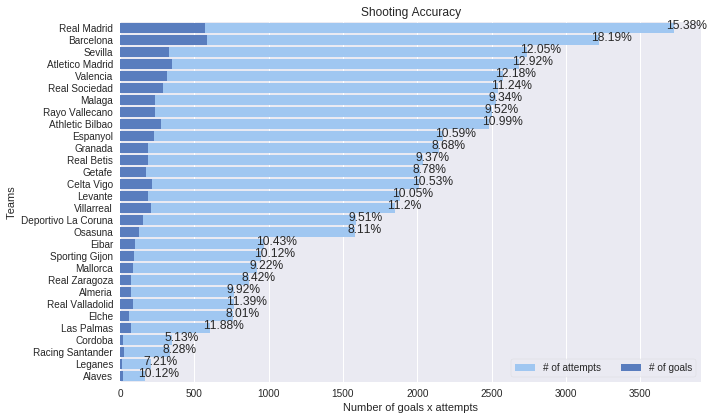

In [75]:
## Creating a dataframe with total of attempts and total goals
result_df = pd.DataFrame({'total': total.dropna(), 'is_goal': group_by_player_is_goal_filtered['id_event']})
## Sorting values by total
result_df.sort_values('total', ascending=False, inplace=True)

## Setting style to dark
sns.set(style="darkgrid")

## Creating figure
f, ax = plt.subplots(figsize=(10, 6))

## Plotting chart
sns.set_color_codes("pastel")
sns.barplot(x="total",
            y=result_df.index,
            data=result_df,
            label="# of attempts", color="b")

sns.set_color_codes("muted")
sns.barplot(x='is_goal',
            y=result_df.index, 
            data=result_df,
            label="# of goals", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Teams",
       xlabel="Number of goals x attempts", title='Shooting Accuracy')

each = result_df['is_goal'].values
the_total = result_df['total'].values
x_position = 50

for i in range(len(ax.patches[:30])):
    ax.text(ax.patches[i].get_width() - x_position, ax.patches[i].get_y() +.50, 
            str(round((each[i]/the_total[i])*100, 2))+'%')
    
sns.despine(left=True, bottom=True)
f.tight_layout()
plt.savefig('ShootingAccuracy.jpg', format='jpg', dpi=1000)

## Goals scored in the 1st 15 minutes and in the last 15 minutes

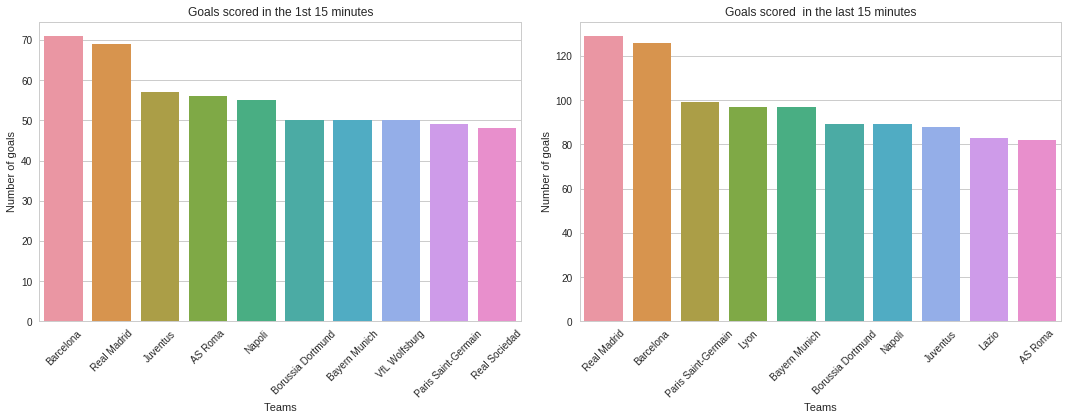

In [76]:
## Filtering out events with time <= 15'
first_15 = df_events[df_events['time'] <= 15]
## Filtering out events with time between 75' and 90'
last_15 = df_events[(df_events['time'] >= 75) & (df_events['time'] <= 90)]

## Grouping by teams for the first 15'
top_10_scorer_first_15 = first_15[first_15['is_goal'] == 1].groupby('event_team').count().sort_values(by='id_event', ascending=False)

## Extracting teams from dataframe
teams = top_10_scorer_first_15.index[:10]
## Extracting number of goals 
scores = top_10_scorer_first_15['id_event'][:10]

## Plotting results
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
ax = sns.barplot(x = [j for j in range(0, len(scores))], y=scores.values, ax=axs[0])
ax.set_xticks([j for j in range(0, len(scores))])
ax.set_xticklabels(teams, rotation=45)
ax.set(xlabel = 'Teams', ylabel = 'Number of goals', title = 'Goals scored in the 1st 15 minutes');

## Grouping by last 15' scorers
top_10_scorer_last_15 = last_15[last_15['is_goal'] == 1].groupby('event_team').count().sort_values(by='id_event', ascending=False)[:10]

## Extracting the names of the teams
teams_last_15 = top_10_scorer_last_15.index[:10]
## Extracting the number of goals
scores_last_15 = top_10_scorer_last_15['id_event'][:10]

## Plottin the results
ax = sns.barplot(x = [j for j in range(0, len(scores_last_15))], y=scores_last_15.values, ax=axs[1])
ax.set_xticks([j for j in range(0, len(scores_last_15))])
ax.set_xticklabels(teams_last_15, rotation=45)
ax.set(xlabel = 'Teams', ylabel = 'Number of goals', title = 'Goals scored  in the last 15 minutes');
plt.savefig('Lastminutewinners.jpg', format='jpg', dpi=1000)
fig.tight_layout()

## penalties full stats

In [79]:
# Penalties
penalties=df_events[df_events["location"]=='Penalty spot']

In [80]:
def pen_full_stats(player):
    player_pen=penalties[penalties["player"]==player]
    scored_pen=player_pen[player_pen["is_goal"]==1]
    missed_pen=player_pen[player_pen["is_goal"]==0]
    
    top_left_rightfoot=scored_pen[scored_pen["shot_place"]=='Top left corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    top_left_leftfoot=scored_pen[scored_pen["shot_place"]=='Top left corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    bot_left_rightfoot=scored_pen[scored_pen["shot_place"]=='Bottom left corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    bot_left_leftfoot=scored_pen[scored_pen["shot_place"]=='Bottom left corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    top_right_rightfoot=scored_pen[scored_pen["shot_place"]=='Top right corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    top_right_leftfoot=scored_pen[scored_pen["shot_place"]=='Top right corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    bot_right_rightfoot=scored_pen[scored_pen["shot_place"]=='Bottom right corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    bot_right_leftfoot=scored_pen[scored_pen["shot_place"]=='Bottom right corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    centre_rightfoot=scored_pen[scored_pen["shot_place"]=='Centre of the goal'][scored_pen["bodypart"]=='right foot'].shape[0]+scored_pen[scored_pen["shot_place"]=='Top centre of the goal'][scored_pen["bodypart"]=='right foot'].shape[0]
    centre_leftfoot=scored_pen[scored_pen["shot_place"]=='Centre of the goal'][scored_pen["bodypart"]=='left foot'].shape[0]+scored_pen[scored_pen["shot_place"]=='Top centre of the goal'][scored_pen["bodypart"]=='left foot'].shape[0]
    scored_without_recorded_loc_rightfoot=scored_pen[scored_pen["shot_place"].isnull()][scored_pen["bodypart"]=='right foot'].shape[0]
    scored_without_recorded_loc_leftfoot=scored_pen[scored_pen["shot_place"].isnull()][scored_pen["bodypart"]=='left foot'].shape[0]
    missed_rightfoot=missed_pen[missed_pen["bodypart"]=='right foot'].shape[0]
    missed_leftfoot=missed_pen[missed_pen["bodypart"]=='left foot'].shape[0]
    
    right_foot=pd.DataFrame({"Top Left Corner":top_left_rightfoot,"Bottom Left Corner":bot_left_rightfoot,"Top Right Corner":top_right_rightfoot,"Bottom Right Corner":bot_right_rightfoot,"Centre":centre_rightfoot,"Unrecorded placement":scored_without_recorded_loc_rightfoot,"Missed":missed_rightfoot},index=["Right Foot attempt"])
    left_foot=pd.DataFrame({"Top Left Corner":top_left_leftfoot,"Bottom Left Corner":bot_left_leftfoot,"Top Right Corner":top_right_leftfoot,"Bottom Right Corner":bot_right_leftfoot,"Centre":centre_leftfoot,"Unrecorded placement":scored_without_recorded_loc_leftfoot,"Missed":missed_leftfoot},index=["Left Foot attempt"])
    
    fullstats=right_foot.append(left_foot)
    fullstats=fullstats[["Top Right Corner","Bottom Right Corner","Top Left Corner","Bottom Left Corner","Centre","Unrecorded placement","Missed"]]
    return fullstats

In [81]:
pen_full_stats("lionel messi")

,Top Right Corner,Bottom Right Corner,Top Left Corner,Bottom Left Corner,Centre,Unrecorded placement,Missed
Right Foot attempt,0,0,0,0,0,0,0
Left Foot attempt,7,8,3,6,5,1,7


In [82]:
pen_full_stats("cristiano ronaldo")

,Top Right Corner,Bottom Right Corner,Top Left Corner,Bottom Left Corner,Centre,Unrecorded placement,Missed
Right Foot attempt,3,14,2,19,3,2,8
Left Foot attempt,0,0,0,0,0,0,0


In [83]:
## Full stats of the player
def full_stats(player):
    player_pen=df_events[df_events["player"]==player]
    scored_pen=player_pen[player_pen["is_goal"]==1]
    missed_pen=player_pen[player_pen["is_goal"]==0]
    
    top_left_rightfoot=scored_pen[scored_pen["shot_place"]=='Top left corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    top_left_leftfoot=scored_pen[scored_pen["shot_place"]=='Top left corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    top_left_head = scored_pen[scored_pen["shot_place"]=='Top left corner'][scored_pen["bodypart"]=='head'].shape[0]
    
    bot_left_rightfoot=scored_pen[scored_pen["shot_place"]=='Bottom left corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    bot_left_leftfoot=scored_pen[scored_pen["shot_place"]=='Bottom left corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    bot_left_head = scored_pen[scored_pen["shot_place"]=='Bottom left corner'][scored_pen["bodypart"]=='head'].shape[0]   
    
    top_right_rightfoot=scored_pen[scored_pen["shot_place"]=='Top right corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    top_right_leftfoot=scored_pen[scored_pen["shot_place"]=='Top right corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    top_right_head = scored_pen[scored_pen["shot_place"]=='Top right corner'][scored_pen["bodypart"]=='head'].shape[0]
    
    bot_right_rightfoot=scored_pen[scored_pen["shot_place"]=='Bottom right corner'][scored_pen["bodypart"]=='right foot'].shape[0]
    bot_right_leftfoot=scored_pen[scored_pen["shot_place"]=='Bottom right corner'][scored_pen["bodypart"]=='left foot'].shape[0]
    bot_right_head = scored_pen[scored_pen["shot_place"]=='Bottom right corner'][scored_pen["bodypart"]=='head'].shape[0]
    
    centre_rightfoot=scored_pen[scored_pen["shot_place"]=='Centre of the goal'][scored_pen["bodypart"]=='right foot'].shape[0]+scored_pen[scored_pen["shot_place"]==11][scored_pen["bodypart"]=='right foot'].shape[0]
    centre_leftfoot=scored_pen[scored_pen["shot_place"]=='Centre of the goal'][scored_pen["bodypart"]=='left foot'].shape[0]+scored_pen[scored_pen["shot_place"]==11][scored_pen["bodypart"]=='left foot'].shape[0]
    centre_head = scored_pen[scored_pen["shot_place"]=='Centre of the goal'][scored_pen["bodypart"]=='head'].shape[0]
    
    scored_without_recorded_loc_rightfoot=scored_pen[scored_pen["shot_place"].isnull()][scored_pen["bodypart"]=='right foot'].shape[0]
    scored_without_recorded_loc_leftfoot=scored_pen[scored_pen["shot_place"].isnull()][scored_pen["bodypart"]=='left foot'].shape[0]
    scored_without_recorded_loc_head=scored_pen[scored_pen["shot_place"].isnull()][scored_pen["bodypart"]=='head'].shape[0]

    missed_rightfoot=missed_pen[missed_pen["bodypart"]=='right foot'].shape[0]
    missed_leftfoot=missed_pen[missed_pen["bodypart"]=='left foot'].shape[0]
    missed_head=missed_pen[missed_pen["bodypart"]=='head'].shape[0]
    
    right_foot=pd.DataFrame({"Top Left Corner":top_left_rightfoot,"Bottom Left Corner":bot_left_rightfoot,"Top Right Corner":top_right_rightfoot,"Bottom Right Corner":bot_right_rightfoot,"Centre":centre_rightfoot,"Unrecorded placement":scored_without_recorded_loc_rightfoot,"Missed":missed_rightfoot},index=["Right Foot attempt"])
    left_foot=pd.DataFrame({"Top Left Corner":top_left_leftfoot,"Bottom Left Corner":bot_left_leftfoot,"Top Right Corner":top_right_leftfoot,"Bottom Right Corner":bot_right_leftfoot,"Centre":centre_leftfoot,"Unrecorded placement":scored_without_recorded_loc_leftfoot,"Missed":missed_leftfoot},index=["Left Foot attempt"])
    head=pd.DataFrame({"Top Left Corner":top_left_head,"Bottom Left Corner":bot_left_head,"Top Right Corner":top_right_head,"Bottom Right Corner":bot_right_head,"Centre":centre_head,"Unrecorded placement":scored_without_recorded_loc_head,"Missed":missed_head},index=["Head attempt"])

    
    fullstats=right_foot.append(left_foot.append(head))
    fullstats=fullstats[["Top Right Corner","Bottom Right Corner","Top Left Corner","Bottom Left Corner","Centre","Unrecorded placement","Missed"]]
    return fullstats

In [84]:
full_stats('lionel messi')

,Top Right Corner,Bottom Right Corner,Top Left Corner,Bottom Left Corner,Centre,Unrecorded placement,Missed
Right Foot attempt,2,11,1,12,4,0,79
Left Foot attempt,22,43,13,52,32,5,585
Head attempt,1,1,0,6,0,0,45
